## Compute ALT-allele effects at each site

In [1]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

DIRECTORY = f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/enhancer-characteristics-enrichment-subset-inference' 

from numpy import linalg as LA
import pandas as pd 
import numpy as np 

import pysam 

import sys 
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

from read_model import read_model
from bases import BASES 

MCHALE_MODEL = read_model(f"{CONSTRAINT_TOOLS}/dist/model-germline-grch38-Nonly.kmerSize-3.trainSet-noncoding.json")

In [3]:
def compute_heat_map(window, embeddings): 
  chromosome = window['chromosome']
  start = int(window['start'])
  end = int(window['end'])

  with pysam.FastaFile(MCHALE_MODEL['genome']) as genome:
    # "fetch" API: https://pysam.readthedocs.io/en/latest/api.html?highlight=fasta#pysam.FastaFile
    # Note that fetch(region=region) does not work if the coordinates in "region" contains commas
    # Workaround is to parse "region" into "chromosome", "start", "end": 
    sequence = genome.fetch(chromosome, start, end)    
    sequence = sequence.upper()

  distances_for_all_sites = []
  mask = np.ones((len(BASES), len(sequence)))
  for site_index, REF in enumerate(sequence): 
    REF_index = BASES.index(REF)
    mask[REF_index, site_index] = 0
    REF_embedding = embeddings[REF_index, site_index]
    distances_for_site = []
    for allele_index in range(len(BASES)): 
      embedding = embeddings[allele_index, site_index]
      delta = REF_embedding - embedding

      # section A.5.2 of https://www.biorxiv.org/content/10.1101/2023.01.11.523679v2
      # details metrics that could be used to quantify distance between embeddings: 
      #    (i) the L1 distance (Manhattan), 
      #    (ii) the L2 distance (Euclidean), 
      #    (iii) the cosine similarity 
      #    (iv) the dot-product (not normalized cosine similarity) 
      distance = LA.norm(delta, 2) 

      distances_for_site.append(distance)
    distances_for_all_sites.append(distances_for_site)
  distances_for_all_sites = np.array(distances_for_all_sites)
  heat_map = distances_for_all_sites.T 

  return heat_map, mask # both indexed as BASES X [site1, site2, ...]

NUCLEOTIDE_TRANSFORMER_MODEL = '500M_human_ref' #@param['500M_human_ref', '500M_1000G', '2B5_1000G', '2B5_multi_species']
SEQUENCE_LENGTH = 501

def fetch_window(window_index): 
  window = pd.read_csv(f'{DIRECTORY}/window-{window_index}.bed', sep='\t')
  assert len(window) == 1
  window = window.iloc[0]
  return window

def fetch_embeddings(window_index): 
  embeddings_filename = f'{DIRECTORY}/window-{window_index}.embeddings.{NUCLEOTIDE_TRANSFORMER_MODEL}.{SEQUENCE_LENGTH}.npy'
  embeddings = np.load(embeddings_filename)
  return embeddings

def compute_heat_map_wrapper(window_index): 
  window = fetch_window(window_index)
  embeddings = fetch_embeddings(window_index)
  return compute_heat_map(window, embeddings)

compute_heat_map_wrapper(window_index=0)

(array([[0.       , 0.       , 0.       , ..., 1.9941801, 0.       ,
         1.9081959],
        [2.595312 , 3.805649 , 2.8977833, ..., 1.6820358, 2.273474 ,
         2.2385428],
        [2.640824 , 2.933897 , 3.8397076, ..., 1.8109329, 1.4833192,
         0.       ],
        [3.4823732, 3.5007   , 2.3707097, ..., 0.       , 2.2311282,
         1.897106 ]], dtype=float32),
 array([[0., 0., 0., ..., 1., 0., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 0.],
        [1., 1., 1., ..., 0., 1., 1.]]))

## Fetch SNVs 

In [4]:
from pack_unpack import pack
from snvs import fetch_SNVs
from colorize import print_json

def get_snvs(window): 
  with pysam.TabixFile(MCHALE_MODEL['mutations']) as mutations, pysam.FastaFile(MCHALE_MODEL['genome']) as genome:
    SNVs = fetch_SNVs(
      mutations, 
      genome, 
      region=pack(window['chromosome'], window['start'], window['end']),
      meta=MCHALE_MODEL, 
      number_chromosomes_min=MCHALE_MODEL['numberChromosomesMin']
    )
  return [
    {
      **SNV,
      'position_offset': SNV['position'] - int(window['start'])
    }
    for SNV in SNVs
  ]

def get_snvs_wrapper(window_index): 
  window = fetch_window(window_index)
  return get_snvs(window)

print_json(get_snvs_wrapper(window_index=0))

[
  {
    "chromosome": "chr1",
    "position": 5814033,
    "REF": "A",
    "ALT": "C",
    "number_ALT_chromosomes": 2,
    "number_chromosomes": 152142,
    "kmer": "TAA",
    "position_offset": 33
  },
  {
    "chromosome": "chr1",
    "position": 5814037,
    "REF": "G",
    "ALT": "C",
    "number_ALT_chromosomes": 1,
    "number_chromosomes": 152066,
    "kmer": "AGG",
    "position_offset": 37
  },
  {
    "chromosome": "chr1",
    "position": 5814038,
    "REF": "G",
    "ALT": "T",
    "number_ALT_chromosomes": 1,
    "number_chromosomes": 152106,
    "kmer": "GGG",
    "position_offset": 38
  },
  {
    "chromosome": "chr1",
    "position": 5814040,
    "REF": "T",
    "ALT": "C",
    "number_ALT_chromosomes": 1,
    "number_chromosomes": 151878,
    "kmer": "GTG",
    "position_offset": 40
  },
  {
    "chromosome": "chr1",
    "position": 5814053,
    "REF": "A",
    "ALT": "G",
    "number_ALT_chromosomes": 9,
    "number_chromosomes": 152084,
    "kmer": "CAC",
    "posi

## Correlate variant-effect predictions with SNVs observed in cohort

zscore quantile: 0.0 - 0.005


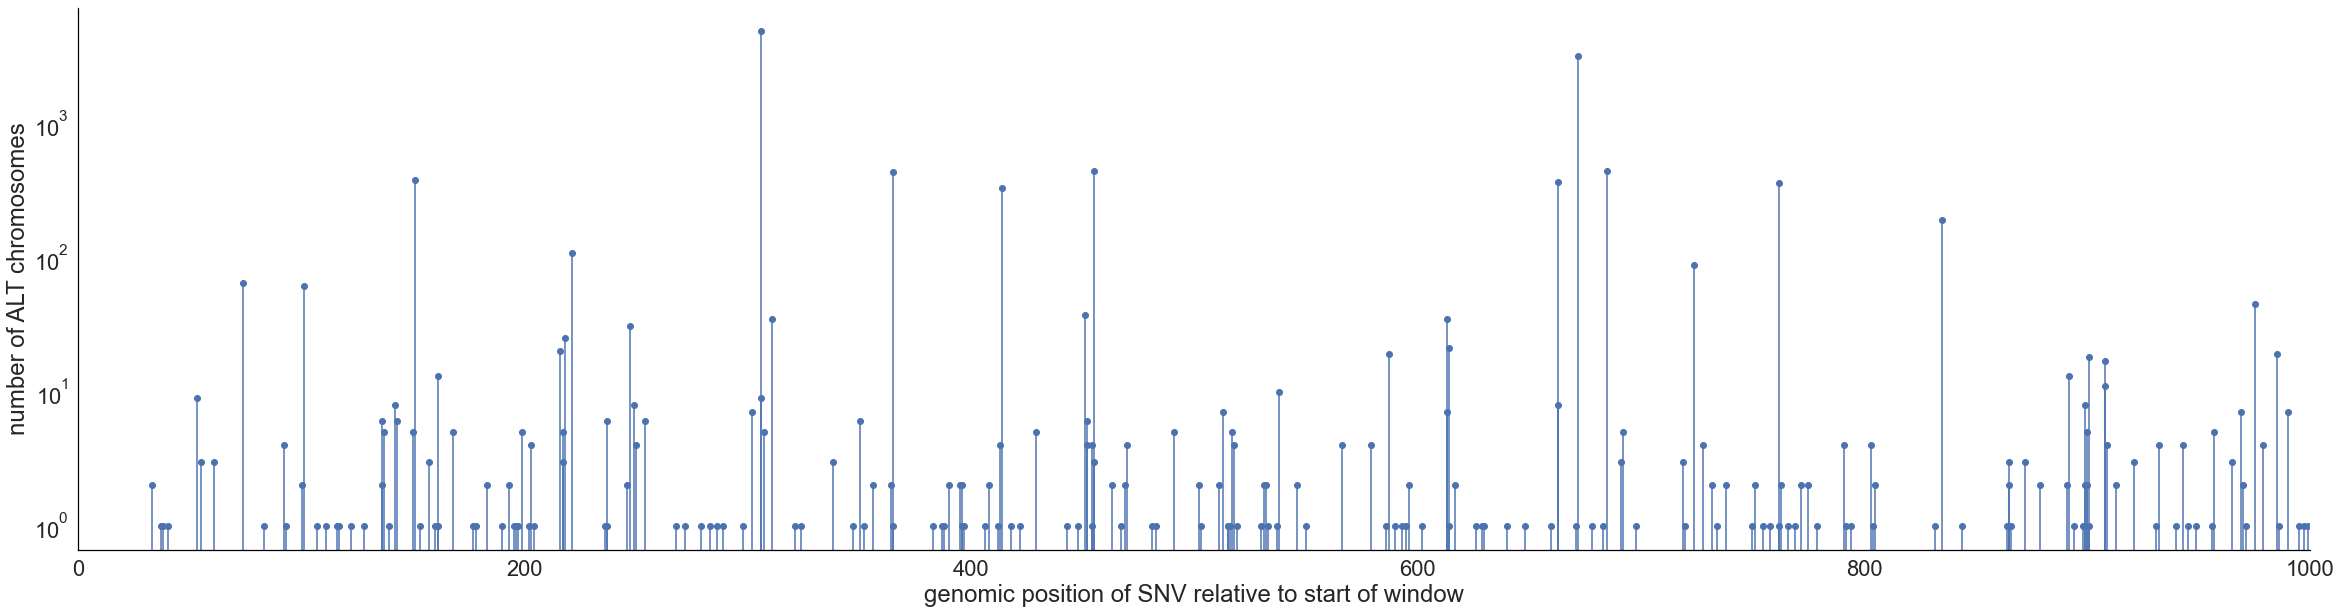

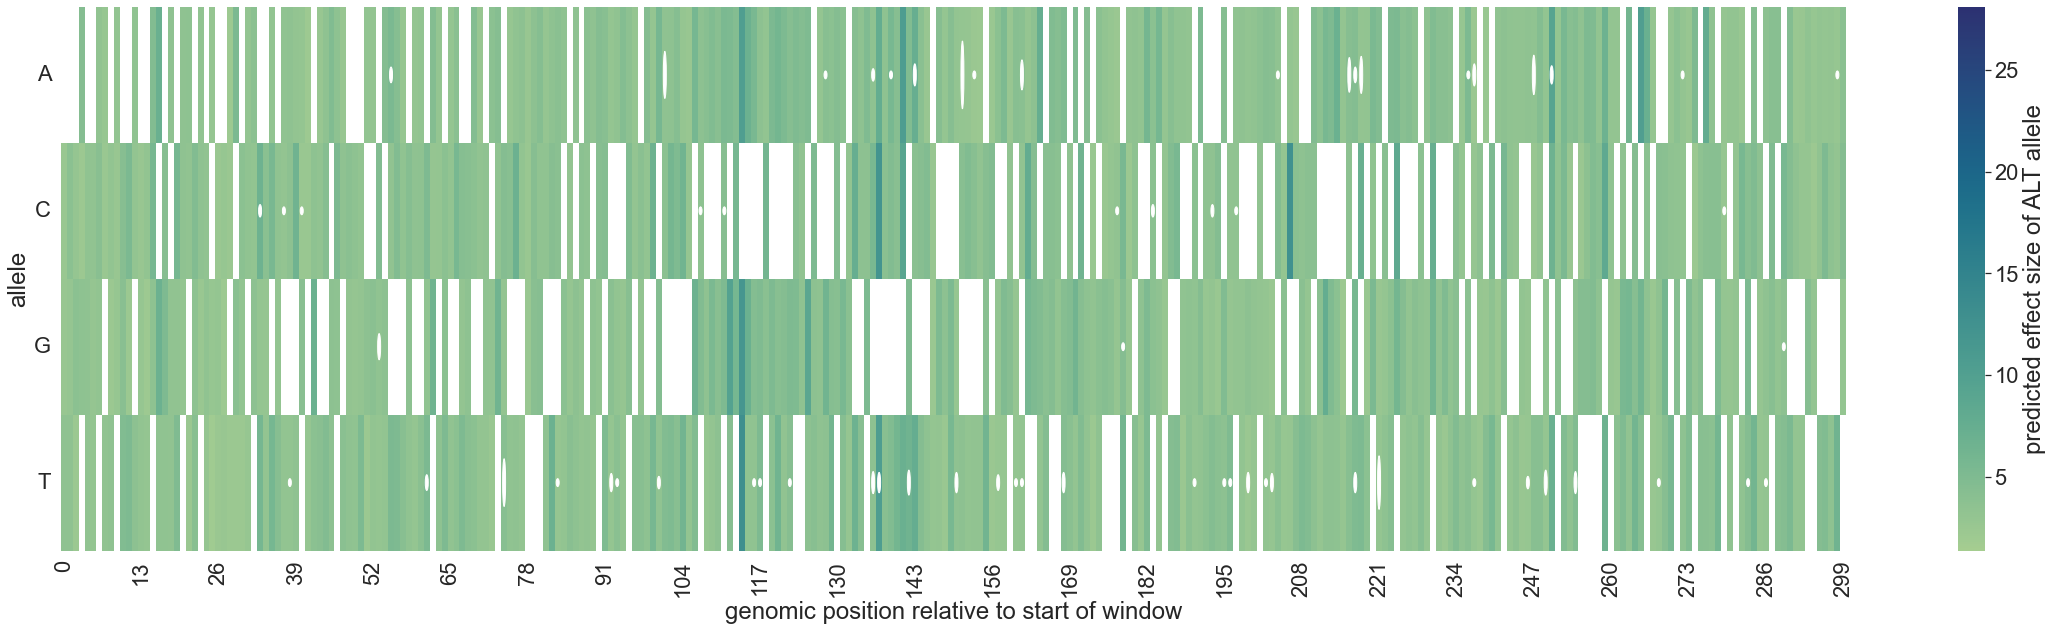

In [5]:
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
sns.set(font_scale=2)

plt.rcParams.update({
  'figure.figsize': (40, 10),
  'axes.facecolor': 'white'
})

from matplotlib.collections import PatchCollection
from matplotlib.patches import Ellipse

def plot_stem(SNVs, linefmt, markerfmt): 
  x = [SNV['position_offset'] for SNV in SNVs]
  y = [SNV['number_ALT_chromosomes'] for SNV in SNVs]

  plt.stem(x, y, linefmt=linefmt, markerfmt=markerfmt)
  plt.yscale('log')
  plt.xlim([0, 1000]) 
  plt.gca().spines['bottom'].set_color('black')
  plt.gca().spines['left'].set_color('black')
  plt.xlabel('genomic position of SNV relative to start of window')
  plt.ylabel('number of ALT chromosomes')
  plt.show()

def create_ellipse(SNV): 
  x = SNV['position_offset'] + 0.5
  y = BASES.index(SNV['ALT']) + 0.5
  log_ALT_count_plus_one = np.log10(SNV['number_ALT_chromosomes']+1)
  log_max_ALT_count_plus_one = np.log10(SNV['number_chromosomes']+1)
  return Ellipse(
    (x,y), 
    width=0.5, 
    height=log_ALT_count_plus_one/log_max_ALT_count_plus_one,
    color='white'
  )

def plot_snvs_and_variant_effects(window_index): 
  window = fetch_window(window_index)
  embeddings = fetch_embeddings(window_index)

  print(f"zscore quantile: {window['negative new chen zscore quantile']}") 

  SNVs = get_snvs(window)
  plot_stem(SNVs, linefmt=None, markerfmt=None)
  
  heat_map, mask = compute_heat_map(window, embeddings)

  # https://seaborn.pydata.org/generated/seaborn.heatmap.html
  ax = sns.heatmap(
      heat_map, 
      cmap = sns.color_palette("crest", as_cmap=True), # https://seaborn.pydata.org/tutorial/color_palettes.html
      center = None, 
      annot = False, 
      # fmt = '.3f',
      # linewidths = 1, 
      cbar_kws = {'label': 'predicted effect size of ALT allele'},
      mask = np.logical_not(mask)
  )
  # ax.invert_yaxis()
  plt.yticks(np.arange(len(BASES))+0.5, list(BASES), rotation=0)
  plt.xlabel('genomic position relative to start of window')
  plt.ylabel('allele')
  plt.xlim([0, 300])

  ellipses = [create_ellipse(SNV) for SNV in SNVs]
  # https://stackoverflow.com/a/71675432 : 
  p = PatchCollection(ellipses, alpha=1, match_original=True)
  ax.add_collection(p)

plot_snvs_and_variant_effects(window_index=0)

zscore quantile: 0.5 - 0.75
mean effect size of all possible ALT alleles: 4.30849027633667
mean effect size of ALT alleles observed in cohort: 4.037075042724609
std of effect size of ALT alleles observed in cohort: 1.5761854648590088


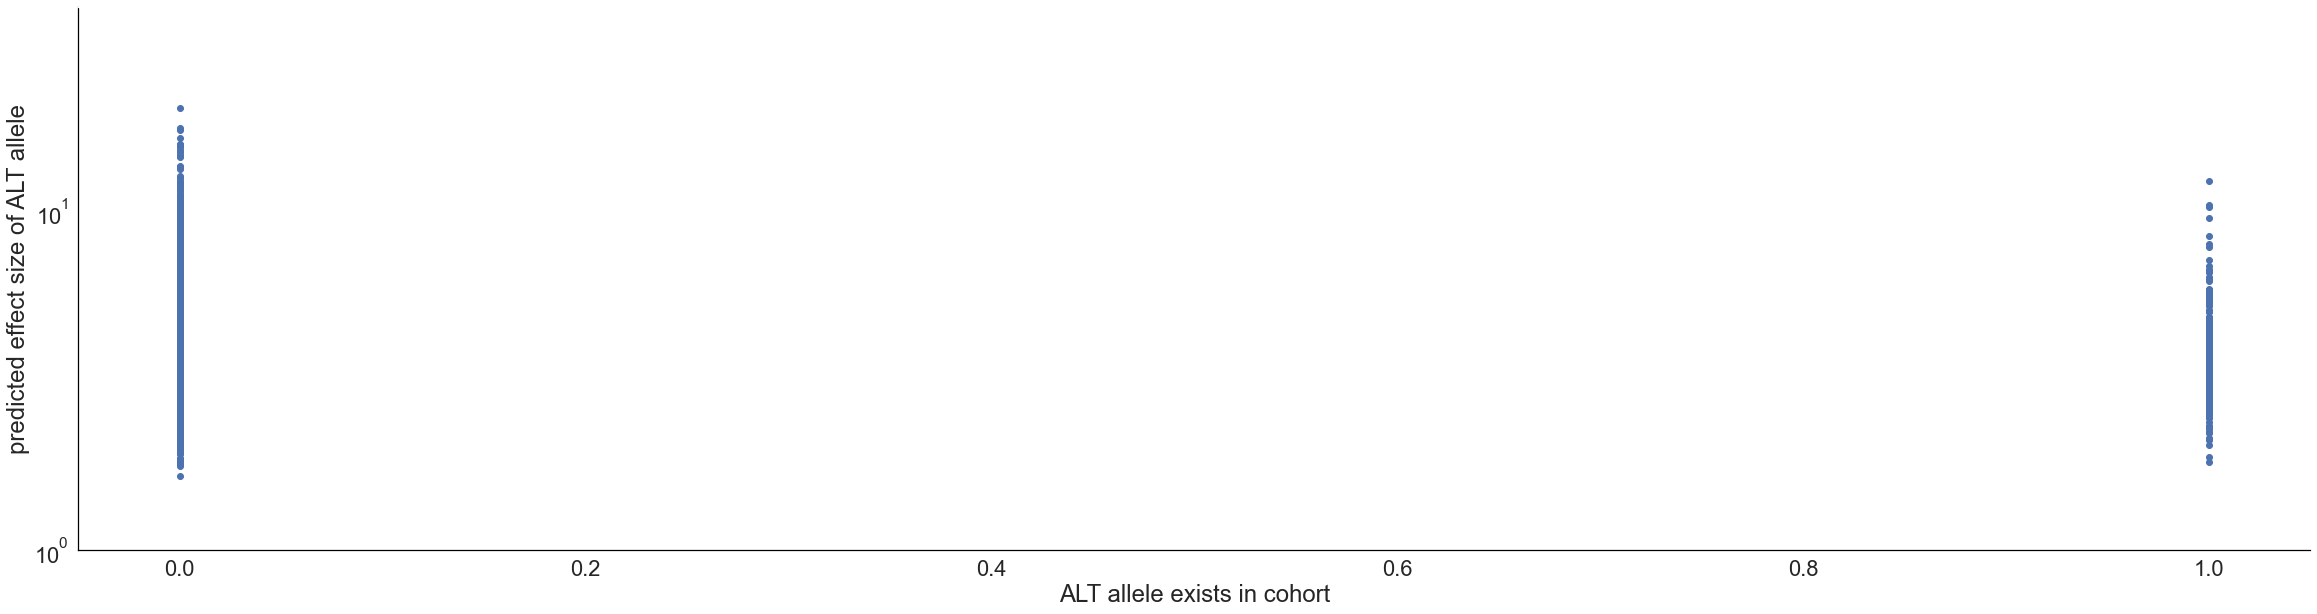

In [142]:
from ravel_unravel import ravel

def correlate_snvs_and_variant_effects(window_index): 
  window = fetch_window(window_index)
  number_sites = int(window['end']) - int(window['start'])

  SNVs = get_snvs(window)

  SNV_present = np.zeros(shape=(len(BASES), number_sites))
  for SNV in SNVs: 
    site_index = SNV['position_offset']
    if site_index >= number_sites: continue
    ALT_index = BASES.index(SNV['ALT'])
    SNV_present[ALT_index, site_index] = 1 

  embeddings = fetch_embeddings(window_index)
  heat_map, mask = compute_heat_map(window, embeddings)

  SNV_present = ravel(SNV_present)
  heat_map = ravel(heat_map)
  mask = ravel(mask)

  mask = np.array(mask, dtype=bool)
  ALT_effect_size = heat_map[mask]
  ALT_exists_in_cohort = SNV_present[mask]
  ALT_exists_in_cohort = np.array(ALT_exists_in_cohort, dtype=bool)

  plt.scatter(ALT_exists_in_cohort, ALT_effect_size)
  plt.ylim([1, 40])
  plt.xlabel('ALT allele exists in cohort')
  plt.ylabel('predicted effect size of ALT allele')
  plt.gca().spines['bottom'].set_color('black')
  plt.gca().spines['left'].set_color('black')
  plt.yscale('log')

  print(f"zscore quantile: {window['negative new chen zscore quantile']}") 

  mean_ALT_effect_size = np.mean(ALT_effect_size)
  print(f'mean effect size of all possible ALT alleles: {mean_ALT_effect_size}')

  mean_ALT_effect_size_in_cohort = np.mean(ALT_effect_size[ALT_exists_in_cohort])
  print(f'mean effect size of ALT alleles observed in cohort: {mean_ALT_effect_size_in_cohort}')
  
  std_ALT_effect_size_in_cohort = np.std(ALT_effect_size[ALT_exists_in_cohort])
  print(f'std of effect size of ALT alleles observed in cohort: {std_ALT_effect_size_in_cohort}')
  
correlate_snvs_and_variant_effects(window_index=71)

## TODO 

In [ ]:
# TODO: 

# 1. why is the max effect size so large for window_index ~ 130? 

# 1. does mean ALT effect size of window correlate with proportion of window covered by enhancer? 
# *** 2. classify variant-effect sizes as "large" and "small", and ask whether variants are depleted in large-effect cells in negative-selection windows, and enriched in those cells in positive-selection windows (I think enrichment is true)!
# 3. is depletion of SNVs relative to the neutral expectation comparable to the observed number of sites with high values of predicted variant-effects? 
# 